# Read video frames

In [ ]:
import cv2
import numpy as np
import torch

def extract_frames(video_path):
    cap = cv2.VideoCapture(video_path)
    frames = []

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frames.append(frame)

    cap.release()
    frames = np.array(frames)
    frames = torch.from_numpy(frames).float().permute(0, 3, 1, 2)  # Convert to (N, C, H, W) format
    return frames

# Example usage
video_path = 'path_to_your_video.mp4'
frames = extract_frames(video_path)
print(f"Extracted {len(frames)} frames with shape {frames.shape} from {video_path}")

# Compute optical flow

In [ ]:
def compute_optical_flow(frames):
    flows = []
    prev_gray = cv2.cvtColor(frames[0].permute(1, 2, 0).numpy().astype(np.uint8), cv2.COLOR_RGB2GRAY)

    for i in range(1, len(frames)):
        gray = cv2.cvtColor(frames[i].permute(1, 2, 0).numpy().astype(np.uint8), cv2.COLOR_RGB2GRAY)
        flow = cv2.calcOpticalFlowFarneback(prev_gray, gray, None,
                                            0.5, 3, 15, 3, 5, 1.2, 0)
        flow = torch.from_numpy(flow).float().permute(2, 0, 1)  # Convert to (2, H, W) format
        flows.append(flow)
        prev_gray = gray

    flows = torch.stack(flows)  # Stack to create (N-1, 2, H, W) tensor
    return flows

# Example usage
flows = compute_optical_flow(frames)
print(f"Computed optical flow for {len(flows)} frame pairs with shape {flows.shape}")

# Save data to .npz

In [ ]:
def save_to_npz(frames, flows, output_file):
    frames = frames.permute(0, 2, 3, 1).numpy()  # Convert to (N, H, W, C) format for saving
    flows = flows.permute(0, 2, 3, 1).numpy()    # Convert to (N-1, H, W, 2) format for saving
    np.savez(output_file, frames=frames, flows=flows)
    print(f"Data saved to {output_file}")

# Example usage
output_file = 'video_data.npz'
save_to_npz(frames, flows, output_file)


# Combined read video and save to .npz

In [ ]:
import cv2
import numpy as np
import torch

def extract_frames(video_path):
    cap = cv2.VideoCapture(video_path)
    frames = []

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frames.append(frame)

    cap.release()
    frames = np.array(frames)
    frames = torch.from_numpy(frames).float().permute(0, 3, 1, 2)  # Convert to (N, C, H, W) format
    return frames

def compute_optical_flow(frames):
    flows = []
    prev_gray = cv2.cvtColor(frames[0].permute(1, 2, 0).numpy().astype(np.uint8), cv2.COLOR_RGB2GRAY)

    for i in range(1, len(frames)):
        gray = cv2.cvtColor(frames[i].permute(1, 2, 0).numpy().astype(np.uint8), cv2.COLOR_RGB2GRAY)
        flow = cv2.calcOpticalFlowFarneback(prev_gray, gray, None,
                                            0.5, 3, 15, 3, 5, 1.2, 0)
        flow = torch.from_numpy(flow).float().permute(2, 0, 1)  # Convert to (2, H, W) format
        flows.append(flow)
        prev_gray = gray

    flows = torch.stack(flows)  # Stack to create (N-1, 2, H, W) tensor
    return flows

def save_to_npz(frames, flows, output_file):
    frames = frames.permute(0, 2, 3, 1).numpy()  # Convert to (N, H, W, C) format for saving
    flows = flows.permute(0, 2, 3, 1).numpy()    # Convert to (N-1, H, W, 2) format for saving
    np.savez(output_file, frames=frames, flows=flows)
    print(f"Data saved to {output_file}")

# Example usage
video_path = 'output_video.mp4'
output_file = 'video_data.npz'

# Extract frames from the video
frames = extract_frames(video_path)
print(f"Extracted {len(frames)} frames with shape {frames.shape} from {video_path}")

# Compute optical flow between consecutive frames
flows = compute_optical_flow(frames)
print(f"Computed optical flow for {len(flows)} frame pairs with shape {flows.shape}")

# Save frames and flows to an .npz file
save_to_npz(frames, flows, output_file)


# Read data from npz

In [ ]:
import cv2
import numpy as np
import torch

def extract_frames(video_path):
    cap = cv2.VideoCapture(video_path)
    frames = []

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frames.append(frame)

    cap.release()
    frames = np.array(frames)
    frames = torch.from_numpy(frames).float().permute(0, 3, 1, 2)  # Convert to (N, C, H, W) format
    return frames

def compute_optical_flow(frames):
    flows = []
    prev_gray = cv2.cvtColor(frames[0].permute(1, 2, 0).numpy().astype(np.uint8), cv2.COLOR_RGB2GRAY)

    for i in range(1, len(frames)):
        gray = cv2.cvtColor(frames[i].permute(1, 2, 0).numpy().astype(np.uint8), cv2.COLOR_RGB2GRAY)
        flow = cv2.calcOpticalFlowFarneback(prev_gray, gray, None,
                                            0.5, 3, 15, 3, 5, 1.2, 0)
        flow = torch.from_numpy(flow).float().permute(2, 0, 1)  # Convert to (2, H, W) format
        flows.append(flow)
        prev_gray = gray

    flows = torch.stack(flows)  # Stack to create (N-1, 2, H, W) tensor
    return flows

# Example usage
video_path = 'output_video.mp4'
frames = extract_frames(video_path)
flows = compute_optical_flow(frames)

# Save frames and flows for future use
output_file = 'video_data.npz'
np.savez(output_file, frames=frames.numpy(), flows=flows.numpy())
print(f"Data saved to {output_file}")


# START FROM HERE (if you have already loaded video data into .npz file)

# Load data

In [1]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

class VideoDataset(Dataset):
    def __init__(self, frames, flows):
        self.frames = frames[:-1]  # All but the last frame
        self.flows = flows         # All flows
        self.targets = frames[1:]  # All frames starting from the second one

    def __len__(self):
        return len(self.flows)

    def __getitem__(self, idx):
        current_frame = self.frames[idx]
        current_flow = self.flows[idx]
        next_frame = self.targets[idx]
        return current_frame, current_flow, next_frame

# Load data from .npz file
data = np.load('video_data.npz')
frames = torch.from_numpy(data['frames']).to(torch.float32).permute(0, 3, 1, 2)  # (N, C, H, W)
flows = torch.from_numpy(data['flows']).to(torch.float32).permute(0, 3, 1, 2)    # (N-1, 2, H, W)

# flows = flows / np.max(np.abs(flows))
frames = frames / 255.0

# # Load optical flow data
# VIDEO_DATA_FILE = 'video_data.npz'
# flow_data = np.load(VIDEO_DATA_FILE)
# flows = flow_data['flows']  # Shape: (N, H, W, 2)

# # Load frames
# frames_data = np.load(VIDEO_DATA_FILE)
# frames = frames_data['frames']  # Shape: (N, H, W, 3)

# # Normalize data
# flows = flows / np.max(np.abs(flows))
# frames = frames / 255.0

# Create dataset and dataloader
dataset = VideoDataset(frames, flows)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

print(f"Dataset size: {len(dataset)}")


Dataset size: 48


In [81]:
# load test data
test_data = np.load("test_data.npz")
test_frames = torch.from_numpy(test_data['frames']).to(torch.float32).permute(0, 3, 1, 2)  # (N, C, H, W)
test_flows = torch.from_numpy(test_data['flows']).to(torch.float32).permute(0, 3, 1, 2)    # (N-1, 2, H, W)
test_frames = test_frames / 255.0

# Build model

In [3]:
import torch.nn as nn
import torch.optim as optim

class FramePredictionModel(nn.Module):
    def __init__(self):
        super(FramePredictionModel, self).__init__()
        self.encoder_frame = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.encoder_flow = nn.Sequential(
            nn.Conv2d(2, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, frame, flow):
        x1 = self.encoder_frame(frame)
        x2 = self.encoder_flow(flow)
        x = torch.cat([x1, x2], dim=1)  # Concatenate along the channel dimension
        x = self.decoder(x)
        return x

# Instantiate the model
model = FramePredictionModel()
print(model)


FramePredictionModel(
  (encoder_frame): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (encoder_flow): Sequential(
    (0): Conv2d(2, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (decoder): Sequential(
    (0): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=T

# Train model

In [10]:
check_gpu = None
if torch.cuda.is_available():
    check_gpu = 'cuda'
elif torch.backends.mps.is_available():
    check_gpu = 'mps'
else:
    check_gpu = 'cpu'
device = torch.device(check_gpu)
model.to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 1000
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for frames, flows, targets in dataloader:
        frames, flows, targets = frames.to(device), flows.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(frames, flows)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(dataloader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")


Epoch [1/1000], Loss: 0.0012
Epoch [2/1000], Loss: 0.0212
Epoch [3/1000], Loss: 0.0108
Epoch [4/1000], Loss: 0.0077
Epoch [5/1000], Loss: 0.0075
Epoch [6/1000], Loss: 0.0064
Epoch [7/1000], Loss: 0.0058
Epoch [8/1000], Loss: 0.0060
Epoch [9/1000], Loss: 0.0060
Epoch [10/1000], Loss: 0.0057
Epoch [11/1000], Loss: 0.0053
Epoch [12/1000], Loss: 0.0052
Epoch [13/1000], Loss: 0.0053
Epoch [14/1000], Loss: 0.0052
Epoch [15/1000], Loss: 0.0051
Epoch [16/1000], Loss: 0.0050
Epoch [17/1000], Loss: 0.0049
Epoch [18/1000], Loss: 0.0049
Epoch [19/1000], Loss: 0.0048
Epoch [20/1000], Loss: 0.0047
Epoch [21/1000], Loss: 0.0047
Epoch [22/1000], Loss: 0.0046
Epoch [23/1000], Loss: 0.0046
Epoch [24/1000], Loss: 0.0045
Epoch [25/1000], Loss: 0.0045
Epoch [26/1000], Loss: 0.0044
Epoch [27/1000], Loss: 0.0044
Epoch [28/1000], Loss: 0.0043
Epoch [29/1000], Loss: 0.0042
Epoch [30/1000], Loss: 0.0042
Epoch [31/1000], Loss: 0.0041
Epoch [32/1000], Loss: 0.0041
Epoch [33/1000], Loss: 0.0040
Epoch [34/1000], Lo

# Evaluate

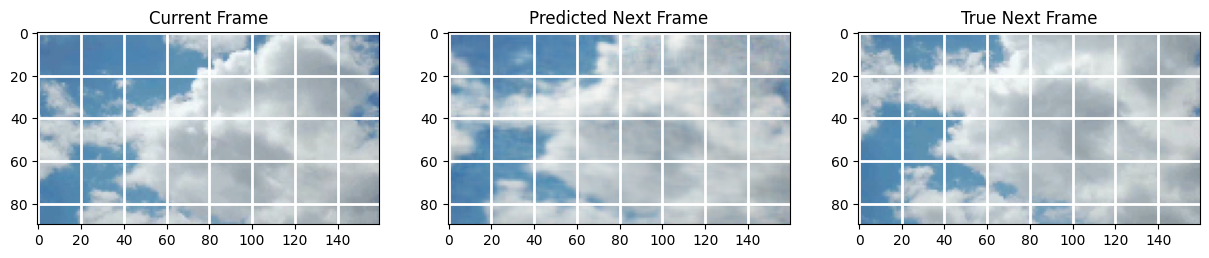

In [13]:
import matplotlib.pyplot as plt

def plot_results(frames, flows, model, n=2):
    model.eval()
    with torch.no_grad():
        current_frame = frames[n:n+1].to(device)  # Select a single frame
        current_flow = flows[n:n+1].to(device)    # Select the corresponding flow
        true_next_frame = frames[n+1:n+2].to(device)
        predicted_frame = model(current_frame, current_flow)
        
        # Move tensors to CPU for plotting
        current_frame = current_frame.cpu().numpy().squeeze().transpose(1, 2, 0)
        current_flow = current_flow.cpu().numpy().squeeze().transpose(1, 2, 0)
        true_next_frame = true_next_frame.cpu().numpy().squeeze().transpose(1, 2, 0)
        predicted_frame = predicted_frame.cpu().numpy().squeeze().transpose(1, 2, 0)

        plt.figure(figsize=(15, 5))
        plt.subplot(1, 3, 1)
        plt.grid(color='w', linestyle='-', linewidth=2)
        plt.imshow(current_frame[...,::-1])
        plt.title('Current Frame')
        plt.subplot(1, 3, 2)
        plt.grid(color='w', linestyle='-', linewidth=2)
        plt.imshow(predicted_frame[...,::-1])
        plt.title('Predicted Next Frame')
        plt.subplot(1, 3, 3)
        plt.grid(color='w', linestyle='-', linewidth=2)
        plt.imshow(true_next_frame[...,::-1])
        plt.title('True Next Frame')
        plt.show()

# Example usage: Plot results
plot_results(frames, flows, model)


In [ ]:
for n in range(10):
    plot_results(test_frames, test_flows, model, n)